<a href="https://colab.research.google.com/github/Rohithv07/4thyearProject/blob/master/ImagePlasticClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary packages

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

import tensorflow_hub as hub

import numpy as np

import pandas as pd

Increasing the precision

In [0]:
pd.set_option("display.precision", 8)

Connecting with the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


You must enter the authorization code when asked

Now set training folder into a data_root

In [0]:
data_root='/content/drive/My Drive/Project/seven_plastics'

Create a data generator for training and validation

In [0]:
IMAGE_SHAPE = (224, 224)

TRAINING_DATA_DIR = str(data_root)

print(TRAINING_DATA_DIR);

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(
    
    TRAINING_DATA_DIR,

    subset="validation",

    shuffle=True,

    target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(
    
TRAINING_DATA_DIR,
subset="training",

shuffle=True,

target_size=IMAGE_SHAPE)

More about the data batches

In [9]:
image_batch_train, label_batch_train = next(iter(train_generator))

print("Image batch shape: ", image_batch_train.shape)

print("Label batch shape: ", label_batch_train.shape)

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])

dataset_labels = np.array([key.title() for key, value in dataset_labels])

print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)
['1_Polyethylene_Pet' '2_High_Density_Polyethylene_Pe-Hd'
 '3_Polyvinylchloride_Pvc' '4_Low_Density_Polyethylene_Pe-Ld'
 '5_Polypropylene_Pp' '6_Polystyrene_Ps' '7_Other_Resins' '8_No_Plastic']


As a base model for transfer learning, we’ll use MobileNet v2 model stored on TensorFlow Hub. This model has advantages to be able to work on Mobile applications.

In [10]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False), 

tf.keras.layers.Dropout(0.4),

tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])  

model.build([None, 224, 224, 3])

model.summary()

model.compile(
    
    optimizer=tf.keras.optimizers.Adam(),

    loss='categorical_crossentropy',
    
     metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  10248     
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


Train our model

In [13]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)

val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
  train_generator,

  epochs=30,

  verbose=1,

  steps_per_epoch=steps_per_epoch,

  validation_data=valid_generator,

  validation_steps=val_steps_per_epoch).history

Epoch 1/30
18/18 [==============================] - 2s 131ms/step - loss: 0.3393 - acc: 0.9094 - val_loss: 1.2803 - val_acc: 0.6165
Epoch 2/30
18/18 [==============================] - 2s 136ms/step - loss: 0.3501 - acc: 0.8895 - val_loss: 1.3014 - val_acc: 0.6466
Epoch 3/30
18/18 [==============================] - 2s 131ms/step - loss: 0.3087 - acc: 0.9112 - val_loss: 1.3086 - val_acc: 0.6165
Epoch 4/30
18/18 [==============================] - 2s 131ms/step - loss: 0.3401 - acc: 0.9004 - val_loss: 1.3253 - val_acc: 0.6391
Epoch 5/30
18/18 [==============================] - 2s 129ms/step - loss: 0.3218 - acc: 0.9040 - val_loss: 1.3197 - val_acc: 0.6391
Epoch 6/30
18/18 [==============================] - 2s 130ms/step - loss: 0.3144 - acc: 0.9149 - val_loss: 1.3300 - val_acc: 0.6466
Epoch 7/30
18/18 [==============================] - 2s 133ms/step - loss: 0.3195 - acc: 0.9076 - val_loss: 1.3175 - val_acc: 0.6391
Epoch 8/30
18/18 [==============================] - 2s 132ms/step - loss: 0.

We export our model after training

In [29]:
PLASTIC_SAVED_MODEL = "saved_models/plastic"

tf.keras.models.save_model(model, PLASTIC_SAVED_MODEL)

plastic_model = tf.keras.models.load_model(PLASTIC_SAVED_MODEL,
                                        
custom_objects={'KerasLayer':hub.KerasLayer})

INFO:tensorflow:Assets written to: saved_models/plastic/assets


INFO:tensorflow:Assets written to: saved_models/plastic/assets


Get images and labels batch from validation dataset generator

In [30]:
val_image_batch, val_label_batch = next(iter(valid_generator))

true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


Now testing our model and predicting for the entire batch


In [32]:
tf_model_predictions = plastic_model.predict(val_image_batch)

tf_pred_dataframe = pd.DataFrame(tf_model_predictions)

tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")

tf_pred_dataframe.head()

Prediction results for the first elements


,1_Polyethylene_Pet,2_High_Density_Polyethylene_Pe-Hd,3_Polyvinylchloride_Pvc,4_Low_Density_Polyethylene_Pe-Ld,5_Polypropylene_Pp,6_Polystyrene_Ps,7_Other_Resins,8_No_Plastic
0,0.82572156,0.00073201,0.05401870,0.01441252,0.10113759,0.00299210,0.00092994,0.00005554
1,0.00002770,0.00002128,0.00000007,0.00004041,0.00011016,0.00003656,0.00002421,0.99973959
2,0.00256302,0.00985905,0.00000829,0.08561578,0.87749994,0.02433205,0.00001027,0.00011156
3,0.00342684,0.00045340,0.01581702,0.00512240,0.95958668,0.00834039,0.00014538,0.00710784
4,0.00471981,0.00000103,0.00001949,0.03293097,0.00037080,0.00403191,0.95792109,0.00000487


Print images batch and labels predictions

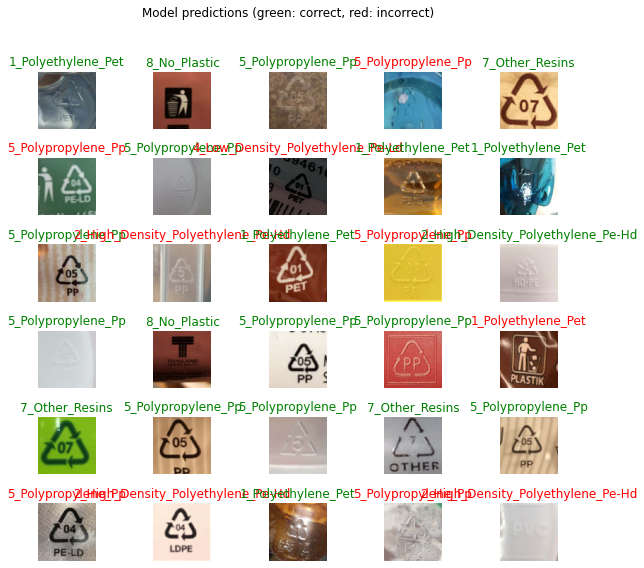

In [39]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)

predicted_labels = dataset_labels[predicted_ids]

plt.figure(figsize=(10,9))

plt.subplots_adjust(hspace=0.5)

for n in range(30):

  plt.subplot(6,5,n+1)

  plt.imshow(val_image_batch[n])

  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"

  plt.title(predicted_labels[n].title(), color=color)

  plt.axis('off')

  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")